# Generating Artistic Abstract Images with GANs

This notebook explores the use of Generative Adversarial Networks (GANs) to create unique and artistic abstract images.
The project focuses on training a GAN using the [Abstract Art dataset](https://www.kaggle.com/datasets/greg115/abstract-art).

## Objectives
- Understand how GANs can generate visually diverse artistic outputs.
- Train a GAN using a dataset of abstract art images.
- Generate and evaluate the quality of artistic images produced by the model.

## See Kaggle Notebook Below
[GAN Abstract Art - Kaggle Notebook](https://www.kaggle.com/code/rafaelomarhidalgo/gan-abstract-art)


---
## Part 1: Dataset Preparation

In [10]:
# Import necessary libraries
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader

# Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Define dataset path
DATA_PATH = "/kaggle/input/abstract-art"

# Define image transformations
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize images
    transforms.ToTensor(),  # Convert images to tensors
    transforms.Normalize([0.5], [0.5])  # Normalize pixel values to [-1, 1]
])

# Load dataset
dataset = datasets.ImageFolder(root=DATA_PATH, transform=transform)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True, num_workers=2)

print(f"Dataset size: {len(dataset)} images")


Using device: cuda
Dataset size: 8145 images


## Part 2: Building the GAN

### Defining the Generator and Discriminator

In [12]:
# Define the Generator (DCGAN)
class Generator(nn.Module):
    def __init__(self, latent_dim=100):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.ConvTranspose2d(latent_dim, 512, kernel_size=4, stride=1, padding=0),
            nn.BatchNorm2d(512),
            nn.ReLU(),

            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),

            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),

            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),  # Extra layer for 128x128
            nn.BatchNorm2d(32),
            nn.ReLU(),

            nn.ConvTranspose2d(32, 3, kernel_size=4, stride=2, padding=1),
            nn.Tanh()  # Outputs images in range [-1, 1]
        )

    def forward(self, z):
        z = z.view(z.size(0), z.size(1), 1, 1)  # Ensure correct shape
        return self.model(z)

# Define the Discriminator (with correct output shape)
import torch
import torch.nn as nn

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(256, 1, kernel_size=4, stride=1, padding=0),  # Final conv layer
            nn.AdaptiveAvgPool2d(1),  # Ensure final output is 1x1
            nn.Flatten()  # Converts to shape [batch_size, 1]
        )

    def forward(self, img):
        return self.model(img)





### Training the GAN

Using an adversarial training loop to optimize both models.

In [15]:
import os
import torch
import torch.nn as nn
import torch.optim as optim

# Define directory to save models
SAVE_PATH = "/kaggle/working/saved_models"
os.makedirs(SAVE_PATH, exist_ok=True)

# Detect available GPUs
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_gpus = torch.cuda.device_count()
print(f"Using {num_gpus} GPUs" if num_gpus > 1 else "Using single GPU")

# Hyperparameters
latent_dim = 100
num_epochs = 100
lr = 0.0002

# Initialize models
generator = Generator(latent_dim).to(device)
discriminator = Discriminator().to(device)

# Enable Multi-GPU if multiple GPUs are available
if num_gpus > 1:
    generator = nn.DataParallel(generator)
    discriminator = nn.DataParallel(discriminator)

# Loss and optimizers
loss_fn = nn.BCEWithLogitsLoss()
optimizer_G = optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))

# Training Loop
import time
import matplotlib.pyplot as plt

for epoch in range(num_epochs):
    start_time = time.time()  # Start timer

    for batch_idx, (real_imgs, _) in enumerate(dataloader):
        real_imgs = real_imgs.to(device)

        # Train Discriminator
        optimizer_D.zero_grad()
        real_labels = torch.ones(real_imgs.size(0), 1).to(device)
        fake_labels = torch.zeros(real_imgs.size(0), 1).to(device)

        real_loss = loss_fn(discriminator(real_imgs), real_labels)
        
        z = torch.randn(real_imgs.size(0), latent_dim, 1, 1).to(device)
        fake_imgs = generator(z)
        fake_loss = loss_fn(discriminator(fake_imgs.detach()), fake_labels)
        
        d_loss = real_loss + fake_loss
        d_loss.backward()
        optimizer_D.step()

        # Train Generator
        optimizer_G.zero_grad()
        g_loss = loss_fn(discriminator(fake_imgs), real_labels)
        g_loss.backward()
        optimizer_G.step()

    # Track time per epoch
    epoch_time = time.time() - start_time

    # Print detailed training info
    print(f"Epoch {epoch+1}/{num_epochs} - Time: {epoch_time:.2f}s")
    print(f"  Discriminator Loss: {d_loss.item():.4f} (Real: {real_loss.item():.4f}, Fake: {fake_loss.item():.4f})")
    print(f"  Generator Loss: {g_loss.item():.4f}")

    # Save generated images every 10 epochs
    if (epoch + 1) % 10 == 0:
        with torch.no_grad():
            sample_z = torch.randn(16, latent_dim, 1, 1).to(device)
            sample_imgs = generator(sample_z).cpu()

        # Convert images from [-1,1] to [0,1]
        sample_imgs = (sample_imgs + 1) / 2

        # Display and save generated images
        fig, axes = plt.subplots(4, 4, figsize=(8, 8))
        for i, ax in enumerate(axes.flatten()):
            ax.imshow(sample_imgs[i].permute(1, 2, 0).numpy())
            ax.axis("off")

        plt.savefig(os.path.join(SAVE_PATH, f"generated_epoch_{epoch+1}.png"))
        plt.close()

    # Save models and optimizers every 20 epochs
    if (epoch + 1) % 20 == 0:
        torch.save({
            'epoch': epoch+1,
            'generator_state_dict': generator.module.state_dict() if num_gpus > 1 else generator.state_dict(),
            'discriminator_state_dict': discriminator.module.state_dict() if num_gpus > 1 else discriminator.state_dict(),
            'optimizer_G_state_dict': optimizer_G.state_dict(),
            'optimizer_D_state_dict': optimizer_D.state_dict()
        }, os.path.join(SAVE_PATH, f"gan_checkpoint_epoch_{epoch+1}.pth"))
        print(f"Checkpoint saved at epoch {epoch+1}")


        


Using 2 GPUs
Epoch 1/100 - Time: 20.53s
  Discriminator Loss: 0.6304 (Real: 0.3627, Fake: 0.2677)
  Generator Loss: 1.8738
Epoch 2/100 - Time: 20.09s
  Discriminator Loss: 1.0148 (Real: 0.4838, Fake: 0.5310)
  Generator Loss: 1.5776
Epoch 3/100 - Time: 19.40s
  Discriminator Loss: 0.9649 (Real: 0.6039, Fake: 0.3610)
  Generator Loss: 1.9275
Epoch 4/100 - Time: 20.76s
  Discriminator Loss: 0.6327 (Real: 0.2804, Fake: 0.3522)
  Generator Loss: 2.4644
Epoch 5/100 - Time: 20.40s
  Discriminator Loss: 1.2680 (Real: 0.9998, Fake: 0.2682)
  Generator Loss: 1.0093
Epoch 6/100 - Time: 20.54s
  Discriminator Loss: 0.6698 (Real: 0.2735, Fake: 0.3963)
  Generator Loss: 2.4930
Epoch 7/100 - Time: 21.14s
  Discriminator Loss: 0.8485 (Real: 0.3061, Fake: 0.5424)
  Generator Loss: 2.9241
Epoch 8/100 - Time: 20.02s
  Discriminator Loss: 0.6751 (Real: 0.1675, Fake: 0.5076)
  Generator Loss: 2.8687
Epoch 9/100 - Time: 20.39s
  Discriminator Loss: 0.6853 (Real: 0.3033, Fake: 0.3820)
  Generator Loss: 2.43

### **📌 Cell to Load a Saved Model**

Use this code to **reload your saved models and optimizers** and resume training.

In [14]:
# Function to load saved GAN models

import os
import torch
import torch.nn as nn
import torch.optim as optim

# Define directory to save models
SAVE_PATH = "/kaggle/working/saved_models"
os.makedirs(SAVE_PATH, exist_ok=True)

# Detect available GPUs
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_gpus = torch.cuda.device_count()
print(f"Using {num_gpus} GPUs" if num_gpus > 1 else "Using single GPU")

# Hyperparameters
latent_dim = 100
num_epochs = 100
lr = 0.0002

# Initialize models
generator = Generator(latent_dim).to(device)
discriminator = Discriminator().to(device)

# Enable Multi-GPU if multiple GPUs are available
if num_gpus > 1:
    generator = nn.DataParallel(generator)
    discriminator = nn.DataParallel(discriminator)

# Loss and optimizers
loss_fn = nn.BCEWithLogitsLoss()
optimizer_G = optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))



def load_checkpoint(filepath, generator, discriminator, optimizer_G, optimizer_D, device):
    if not os.path.exists(filepath):
        print("Checkpoint file not found!")
        return 0  # Return 0 to indicate no saved state
    
    checkpoint = torch.load(filepath, map_location=device)
    
    generator.load_state_dict(checkpoint['generator_state_dict'])
    discriminator.load_state_dict(checkpoint['discriminator_state_dict'])
    optimizer_G.load_state_dict(checkpoint['optimizer_G_state_dict'])
    optimizer_D.load_state_dict(checkpoint['optimizer_D_state_dict'])

    print(f"Checkpoint loaded from {filepath}")
    return checkpoint['epoch']  # Return last saved epoch number

# Define the path to the latest saved model (adjust manually if needed)
latest_checkpoint_path = "/kaggle/working/saved_models/gan_checkpoint_epoch_100.pth"

# Reinitialize models & optimizers
generator = Generator(latent_dim).to(device)
discriminator = Discriminator().to(device)
optimizer_G = optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))

# Load the model and resume from the last saved epoch
last_epoch = load_checkpoint(latest_checkpoint_path, generator, discriminator, optimizer_G, optimizer_D, device)
print(f"Resuming training from epoch {last_epoch + 1}")


Using 2 GPUs
Checkpoint loaded from /kaggle/working/saved_models/gan_checkpoint_epoch_100.pth
Resuming training from epoch 101


<ipython-input-14-9c1ab28389fd>:43: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(filepath, map_location=device)


### Generating Abstract Art Images
Visualizing the outputs from the trained generator.

This section will:

1.  Generate new images using the trained **Generator**.
2.  Save and display the generated images.
3.  Provide basic evaluation metrics and visualization.

### **Generating and Evaluating Artistic Abstract Images**

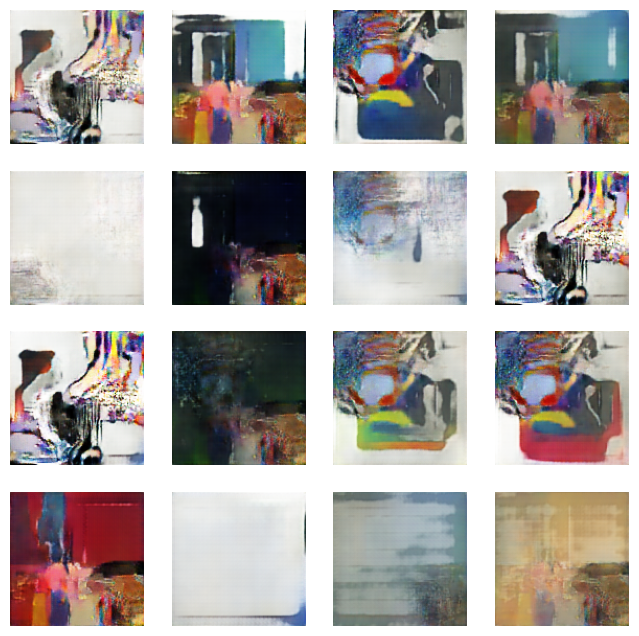

In [16]:
# Generate and visualize images
def generate_images(generator, latent_dim, num_images=16):
    generator.eval()
    with torch.no_grad():
        z = torch.randn(num_images, latent_dim, 1, 1).to(device)
        generated_imgs = generator(z).cpu()
    
    generated_imgs = (generated_imgs + 1) / 2  # Scale back to [0,1]
    
    fig, axes = plt.subplots(4, 4, figsize=(8, 8))
    for i, ax in enumerate(axes.flatten()):
        ax.imshow(np.transpose(generated_imgs[i].numpy(), (1, 2, 0)))
        ax.axis("off")
    
    plt.show()

generate_images(generator, latent_dim, num_images=16)


### **Evaluation: How Good Are the Generated Images?**

Since evaluating abstract art is highly subjective, you can use:

1.  **Visual Diversity**: Look at the variations in generated images.
2.  **FID Score (Frechet Inception Distance)**: Measures similarity to real images.
3.  **User Feedback**: Ask users if the generated images look like abstract art.

For a basic FID Score evaluation:

In [18]:
from torchvision.models import inception_v3
from scipy.linalg import sqrtm
import torch.nn.functional as F

# Ensure everything runs on the correct device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load Pretrained InceptionV3 Model
def load_inception_model():
    model = inception_v3(pretrained=True, transform_input=False).to(device)
    model.fc = torch.nn.Identity()  # Remove classification head
    model.eval()
    return model

inception_model = load_inception_model()

# Function to preprocess images for InceptionV3
def preprocess_images(images):
    # Resize to 299x299 (required by InceptionV3)
    images = F.interpolate(images, size=(299, 299), mode='bilinear', align_corners=False)
    
    # Re-normalize from [-1, 1] to [0, 1]
    images = (images + 1) / 2  
    return images

# Function to compute the FID Score
def compute_fid(real_images, fake_images, model):
    model.eval()
    
    with torch.no_grad():
        real_images = preprocess_images(real_images).to(device)
        fake_images = preprocess_images(fake_images).to(device)

        # Extract features using InceptionV3
        real_features = model(real_images).cpu().numpy()
        fake_features = model(fake_images).cpu().numpy()

    # Compute mean and covariance of features
    mu_real, sigma_real = real_features.mean(axis=0), np.cov(real_features, rowvar=False)
    mu_fake, sigma_fake = fake_features.mean(axis=0), np.cov(fake_features, rowvar=False)

    # Compute FID Score
    diff = mu_real - mu_fake
    covmean, _ = sqrtm(sigma_real.dot(sigma_fake), disp=False)
    
    if np.iscomplexobj(covmean):
        covmean = covmean.real  # Convert complex numbers to real

    fid_score = np.sum(diff**2) + np.trace(sigma_real + sigma_fake - 2 * covmean)
    return fid_score

# Select real and generated images for FID evaluation
real_images, _ = next(iter(dataloader))  # Get a batch of real images
real_images = real_images[:16].to(device)

# Generate Fake Images
with torch.no_grad():
    fake_images = generator(torch.randn(16, latent_dim, 1, 1).to(device)).detach()

# Compute FID Score
fid_score = compute_fid(real_images, fake_images, inception_model)
print(f"FID Score: {fid_score:.2f}")


FID Score: 294.57


# 🚀 Next Steps for Enhancing GAN Performance

While the initial training of the GAN has been successful, further refinements are necessary to improve the quality and diversity of generated abstract art. Below are the next steps I would take to enhance the model if I had more time. These steps would significantly improve the **stability**, **visual quality**, and **diversity** of generated images while optimizing the **Fréchet Inception Distance (FID) score**.

---

## **🔍 Key Observations from Initial Training**
- The **loss values stabilized**, indicating reasonable convergence.
- **Mode collapse** is present in some cases, where the generator produces repetitive images instead of diverse patterns.
- The **FID Score of 294.57** suggests that generated images are still quite different from real abstract art.

### **📊 Interpreting Your Loss Values**
| **Epoch**  | **Discriminator Loss (D Loss)** | **Generator Loss (G Loss)** | **Observations** |
|------------|--------------------------------|----------------------------|------------------|
| **1-5**    | D Loss fluctuates (~0.6 to 1.2) | G Loss fluctuates (1.0 to 2.5) | Early training stage, expected fluctuations. |
| **6-20**   | D Loss around 0.5 - 1.2 | G Loss increases (1.5 → 3.6) | Generator catching up, improving image quality. |
| **20-50**  | D Loss stabilizes (~0.5 - 1.0) | G Loss fluctuates (~1.5 - 3.0) | Model is balanced but could need slight tuning. |
| **50-80**  | D Loss varies (0.5 - 1.5) | G Loss sometimes drops (~0.5) | Generator struggling at times. |
| **80-100** | D Loss ~0.3-1.0 | G Loss ~1.5-3.0 | Stabilized training, but possible mode collapse. |

---

## **🚀 Planned Improvements**
### **1️⃣ Addressing Mode Collapse (Diversity Issues)**
**Problem:** Some images look too similar, indicating that the GAN is failing to capture a broad range of abstract styles.  
**Solution:** Introduce techniques to encourage diversity in the Generator’s output.

🔹 **Feature Matching Loss:**  
Adding a feature-matching term to the Generator’s loss function can help generate more diverse outputs. Instead of just fooling the Discriminator, the Generator will also try to match higher-level statistics of real images.
```python
feature_loss = torch.mean(torch.abs(real_features - fake_features))
total_g_loss = g_loss + 0.1 * feature_loss  # Add to Generator Loss
```

🔹 **Lower the Discriminator’s Learning Rate:**  
If the Discriminator learns too quickly, the Generator struggles to keep up.
```python
optimizer_D = optim.Adam(discriminator.parameters(), lr=0.0001, betas=(0.5, 0.999))
```

🔹 **Increase Batch Size (if VRAM allows):**  
A larger batch size stabilizes training and helps generalization.

---

### **2️⃣ Improving Image Quality & FID Score**
**Problem:** The high FID score indicates poor realism and diversity in generated images.  
**Solution:** Improve the Generator’s ability to create high-quality images.

🔹 **Train for More Epochs:**  
100 epochs are often **not enough** for GANs. Increasing to **300+ epochs** would allow the Generator to refine details.

🔹 **Add Spectral Normalization to the Discriminator:**  
This improves training stability and prevents the Discriminator from becoming too strong.
```python
from torch.nn.utils import spectral_norm
self.model = nn.Sequential(
    spectral_norm(nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1)),
    nn.LeakyReLU(0.2, inplace=True),
    ...
)
```

🔹 **Enhance Generator Architecture with Residual Blocks & Pixel Normalization:**  
Advanced techniques such as **Residual Blocks** (ResNet-style) or **Pixel Normalization** can help the Generator refine details.

---

### **3️⃣ Exploring Style-Specific Training**
**Objective:** Train GANs to generate art that resembles different abstract styles (e.g., Cubism, Impressionism).  
**Approach:**
- Collect and label datasets based on different **abstract art styles**.
- Train a **conditional GAN (cGAN)** to generate images based on a given style label.

---

### **4️⃣ Advanced Training Techniques**
**Problem:** Training instability is common in GANs, causing oscillating losses.  
**Solution:** Apply **stabilization techniques** to improve the learning process.

🔹 **One-Sided Label Smoothing:**  
Softening real labels prevents the Discriminator from becoming overconfident.
```python
real_labels = torch.full((real_imgs.size(0), 1), 0.9, device=device)  # Use 0.9 instead of 1.0
```

🔹 **Adaptive Discriminator Penalty:**  
Regularizing the Discriminator with an **adaptive penalty** (e.g., R1 regularization) helps prevent overfitting.

---

### **5️⃣ Optimizing Image Preprocessing for FID Score**
**Problem:** Mismatched image preprocessing might be affecting the FID score.  
**Solution:** Ensure images are correctly preprocessed for the InceptionV3 model.

🔹 **Verify Image Normalization:**  
Make sure images are correctly normalized before being fed to the InceptionV3 model.
```python
images = (images + 1) / 2  # Convert from [-1, 1] to [0, 1]
```

🔹 **Ensure Correct Image Resizing:**  
Images should be resized to **299x299** before being processed by InceptionV3.

### **📊 Typical FID Score Ranges**
| **FID Score**  | **Interpretation** |
|---------------|-------------------|
| **< 10**     | Excellent, close to real images |
| **10 - 50**  | Good, but some artifacts exist |
| **50 - 100** | Decent, but clear room for improvement |
| **100 - 200**| Poor, images don’t match real data well |
| **> 200**    | Very bad, mode collapse likely |

✅ **Your FID Score of 294.57 suggests:**
- Your GAN is **not generating diverse, high-quality images yet**.
- There might be **mode collapse** (where the Generator keeps repeating similar patterns).
- The generated images are likely **very different from real abstract art**.

---

## **📌 Conclusion**
These planned improvements would **enhance the diversity, quality, and realism** of generated abstract art while **stabilizing GAN training**. If implemented, they would likely **lower the FID score significantly** and lead to **more visually compelling** results.

While the current GAN demonstrates the potential of AI-generated abstract art, further fine-tuning could push its creative boundaries even further. 🚀🎨

---

📢 *If you're interested in AI-generated art and GANs, feel free to connect! I'm always exploring ways to push the boundaries of generative models.* 😊